# External Dependencies

In [137]:
# Required for environment
import gym
from gym import spaces
from gym.utils import seeding

# torch is used for the neural network
import torch
from torch.autograd import Variable
import torchvision.transforms as T

# visualization libraries
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

# standard Python libraries
import math
import numpy as np
import time
import logging                                
import copy
import random

# Environment Definition
Modified from original source: https://github.com/hardmaru/estool/blob/master/custom_envs/cartpole_swingup.py

In [138]:
"""
Cart pole swing-up: Original version from:
https://github.com/zuoxingdong/DeepPILCO/blob/master/cartpole_swingup.py

Modified so that done=True when x is outside of -2.4 to 2.4
Reward is also reshaped to be similar to PyBullet/roboschool version

More difficult, since dt is 0.05 (not 0.01), and only 200 timesteps
"""

logger = logging.getLogger(__name__)

class CartPoleSwingUpEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : 50
    }

    def __init__(self):
        self.g = 9.82  # gravity
        self.m_c = 0.5  # cart mass
        self.m_p = 0.5  # pendulum mass
        self.total_m = (self.m_p + self.m_c)
        self.l = 0.6 # pole's length
        self.m_p_l = (self.m_p*self.l)
        self.force_mag = 10.0
        self.dt = 0.01  # seconds between state updates
        self.b = 0.1  # friction coefficient

        self.t = 0 # timestep
        self.t_limit = 500

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        high = np.array([
            np.finfo(np.float32).max,
            np.finfo(np.float32).max,
            np.finfo(np.float32).max,
            np.finfo(np.float32).max,
            np.finfo(np.float32).max])

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high)

        self._seed()
        self.viewer = None
        self.state = None

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        # Valid action
        # action = np.clip(action, -1.0, 1.0)[0]
        # action *= self.force_mag
        if action == 0:
            action = -1
        action *= (self.force_mag)
        
        state = self.state
        x, x_dot, theta, theta_dot = state

        s = math.sin(theta)
        c = math.cos(theta)

        xdot_update = (-2*self.m_p_l*(theta_dot**2)*s + 3*self.m_p*self.g*s*c + 4*action - 4*self.b*x_dot)/(4*self.total_m - 3*self.m_p*c**2)
        thetadot_update = (-3*self.m_p_l*(theta_dot**2)*s*c + 6*self.total_m*self.g*s + 6*(action - self.b*x_dot)*c)/(4*self.l*self.total_m - 3*self.m_p_l*c**2)
        x = x + x_dot*self.dt
        theta = theta + theta_dot*self.dt
        x_dot = x_dot + xdot_update*self.dt
        theta_dot = theta_dot + thetadot_update*self.dt

        self.state = (x,x_dot,theta,theta_dot)

        done = False
        dead = False
        if  x < -self.x_threshold or x > self.x_threshold:
            dead = True
            done = True

        self.t += 1

        if self.t >= self.t_limit:
            done = True
        '''Original Reward Function'''
        # reward_theta = (np.cos(theta)+1.0)/2.0
        # reward_theta = np.cos(theta)
        
        '''Various Experiments'''
#         two_pi = np.pi * 2
#         reward_theta = (np.e**(np.cos(theta)+1.0)-1.0) / two_pi
#         reward_x = np.cos((x/self.x_threshold)*(np.pi/2.0))
#         # scaled_reward_theta = reward_theta / (2.0 * np.pi)
#         reward_theta_dot = (np.cos(theta) * (np.e**(np.cos(theta_dot)+1.0)-1.0) /  (2.0 * np.pi)) + 1.0
#         #reward_x_dot = (np.cos(theta) * (np.e**(np.cos(x_dot)+1.0) - 1) / (2.0 * np.pi)) + 1.0
#         reward_x_dot = 0
#         #reward = reward_theta*reward_x
#         #reward = reward_theta*reward_x*reward_theta_dot
#         reward = (reward_theta + reward_x + reward_theta_dot + reward_x_dot) / 4.0
        
        ''' opt1
        reward_theta = (np.e**(np.cos(theta)+1.0)-1.0) / (2.0 * np.pi)
        reward_x = np.cos((x/self.x_threshold)*(np.pi/2.0))
        reward_theta_dot = reward_theta * (np.e**(np.cos(theta)+1.0)-1.0) /  (2.0 * np.pi)
        reward = (reward_theta + reward_x + reward_theta_dot) / 3.0
        '''
        
        '''opt2
        reward_theta = (np.e**(np.cos(theta)+1.0)-1.0)
        reward_x = np.cos((x/self.x_threshold)*(np.pi/2.0))
        reward_theta_dot = reward_theta * (np.e**(np.cos(theta_dot)+1.0)-1.0) /  (2.0 * np.pi)
        reward = (reward_theta + reward_x + reward_theta_dot) / 3.0
        '''
        
        #opt3
        two_pi = 2 * np.pi
        reward_theta = (np.e**(np.cos(theta)+1.0)-1.0)
        reward_x = np.cos((x/self.x_threshold)*(np.pi/2.0))
        reward_theta_dot = (np.cos(theta) * (np.e**(np.cos(theta_dot)+1.0)-1.0) /  two_pi) + 1.0
        reward_x_dot =  ((np.cos(theta) * (np.e**(np.cos(x_dot)+1.0) - 1) / two_pi) + 1.0)
        reward = (reward_theta + reward_x + reward_theta_dot + reward_x_dot) / 4.0
        
        if dead:
            reward = reward * (1.0 - ((self.t_limit - self.t) / self.t_limit)) 
        

        obs = np.array([x,x_dot,np.cos(theta),np.sin(theta),theta_dot])

        return obs, reward, done, {}

    def reset(self):
        #self.state = self.np_random.normal(loc=np.array([0.0, 0.0, 30*(2*np.pi)/360, 0.0]), scale=np.array([0.0, 0.0, 0.0, 0.0]))
        self.state = np.random.normal(loc=np.array([0.0, 0.0, np.pi, 0.0]), scale=np.array([0.2, 0.2, 0.2, 0.2]))
        self.steps_beyond_done = None
        self.t = 0 # timestep
        x, x_dot, theta, theta_dot = self.state
        obs = np.array([x,x_dot,np.cos(theta),np.sin(theta),theta_dot])
        return obs

    def render(self, mode='human', close=False):
        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return

        screen_width = 600
        screen_height = 600 # before was 400

        world_width = 5  # max visible position of cart
        scale = screen_width/world_width
        carty = screen_height/2 # TOP OF CART
        polewidth = 6.0
        polelen = scale*self.l  # 0.6 or self.l
        cartwidth = 40.0
        cartheight = 20.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
  
            l,r,t,b = -cartwidth/2, cartwidth/2, cartheight/2, -cartheight/2
  
            cart = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            cart.set_color(1, 0, 0)
            self.viewer.add_geom(cart)
  
            l,r,t,b = -polewidth/2,polewidth/2,polelen-polewidth/2,-polewidth/2
            pole = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
            pole.set_color(0, 0, 1)
            self.poletrans = rendering.Transform(translation=(0, 0))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
  
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(0.1, 1, 1)
            self.viewer.add_geom(self.axle)
  
            # Make another circle on the top of the pole
            self.pole_bob = rendering.make_circle(polewidth/2)
            self.pole_bob_trans = rendering.Transform()
            self.pole_bob.add_attr(self.pole_bob_trans)
            self.pole_bob.add_attr(self.poletrans)
            self.pole_bob.add_attr(self.carttrans)
            self.pole_bob.set_color(0, 0, 0)
            self.viewer.add_geom(self.pole_bob)

            self.wheel_l = rendering.make_circle(cartheight/4)
            self.wheel_r = rendering.make_circle(cartheight/4)
            self.wheeltrans_l = rendering.Transform(translation=(-cartwidth/2, -cartheight/2))
            self.wheeltrans_r = rendering.Transform(translation=(cartwidth/2, -cartheight/2))
            self.wheel_l.add_attr(self.wheeltrans_l)
            self.wheel_l.add_attr(self.carttrans)
            self.wheel_r.add_attr(self.wheeltrans_r)
            self.wheel_r.add_attr(self.carttrans)
            self.wheel_l.set_color(0, 0, 0)  # Black, (B, G, R)
            self.wheel_r.set_color(0, 0, 0)  # Black, (B, G, R)
            self.viewer.add_geom(self.wheel_l)
            self.viewer.add_geom(self.wheel_r)

            self.track = rendering.Line((screen_width/2 - self.x_threshold*scale,carty - cartheight/2 - cartheight/4),
              (screen_width/2 + self.x_threshold*scale,carty - cartheight/2 - cartheight/4))
            self.track.set_color(0,0,0)
            self.viewer.add_geom(self.track)

        if self.state is None: return None

        x = self.state
        cartx = x[0]*scale+screen_width/2.0 # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(x[2])
        self.pole_bob_trans.set_translation(-self.l*np.sin(x[2]), self.l*np.cos(x[2]))

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

# Control Parameters & Static Variables

In [139]:
# Global parameters that do not change
env = CartPoleSwingUpEnv()
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

# number of episodes to be used for training
episodes = 1000
# number of episodes to be used for video rendering
video_episodes = 10

# the number of hidden layers in the neural network
n_hidden = 50
# learning rate
lr = 0.001

# Visualization Utilities

In [140]:
# Modified from Original source: https://github.com/ritakurban/Practical-Data-Science/blob/master/DQL_CartPole.ipynb
# Helper function to capture an image of the robot
def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)


In [141]:
# Draw the robot in Jupyter (Not strictly necessary)
def render_scene():
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(), interpolation='none')
    plt.show()

In [142]:
# Plotting Utility
# Soure: https://github.com/ritakurban/Practical-Data-Science/blob/master/DQL_CartPole.ipynb
def plot_res(values, title=''):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    f.suptitle(title)
    ax[0].plot(values, label='Score per run')
    ax[0].axhline(195, c='red', ls='--', label='Goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    
    # Make Trendline
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x, p(x), '--', label='Trend')
    except:
        print('')
        
    # Make Histogram
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='Goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [143]:
# Helper function to encapsulate the different visualizations
def draw(values, title='', show_plot=True, show_scene=False):
    clear_output(wait=True)
    if show_scene:
        render_scene()
    if show_plot:
        plot_res(values, title)

# Data Models for Deep Q-Learning

In [144]:
# defining attributes for deep-Q learning
# Source: https://github.com/ritakurban/Practical-Data-Science/blob/master/DQL_CartPole.ipynb
class DQN():
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim)
            )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        
    def update(self, state, y):
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def predict(self, state):
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [145]:
# Data model for Deep Q-Learning with Replay
# Source: https://github.com/ritakurban/Practical-Data-Science/blob/master/DQL_CartPole.ipynb
class DQN_replay(DQN):
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

In [146]:
# Data model for Double Deep Q-Learning with Replay
# Source: https://github.com/ritakurban/Practical-Data-Science/blob/master/DQL_CartPole.ipynb
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

# Experiment Definitions
Defines how each agent should be run

In [147]:
# Experiment to run a Random Search; Used as a baseline
# Source: https://github.com/ritakurban/Practical-Data-Science/blob/master/DQL_CartPole.ipynb
def random_search(env, episodes, title='Random Strategy'):
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            total += reward
            if done:
                break
        final.append(total)
        draw(final, title)

In [148]:
# experiment for all for training all of the q-learning data models
# Source: https://github.com/ritakurban/Practical-Data-Science/blob/master/DQL_CartPole.ipynb
def q_learning(env, model, episodes, gamma=0.9, epsilon=0.3,
               eps_decay=0.99, replay=False, replay_size=20,
               title='DQL', double=False, n_update=10,
               soft=False, verbose=True, render=False):
    final = []
    memory = []
    episode_i = 0
    sum_total_replay_time = 0
    for episode in range(episodes):
        episode_i += 1
        if double and not soft:
            if episode & n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
            
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            if render:
                env.render()
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
                
            next_state, reward, done, _ = env.step(action)
            
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
            
            if done:
                if not replay:
                    q_values[action] = reward
                    model.update(state, q_values)
                break
            
            if replay:
                t0=time.time()
                model.replay(memory, replay_size, gamma)
                t1 = time.time()
                sum_total_replay_time += (t1-t0)
            else:
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)
            
            state = next_state
        
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        if not render:
            draw(final, title)
        
        if verbose:
            print('Episode: {}, Total Reward: {}'.format(episode_i, total))
            if replay:
                print('Average Replay Time: ', sum_total_replay_time / episode_i)
    return final

# Training Scripts
Used to train the various data models

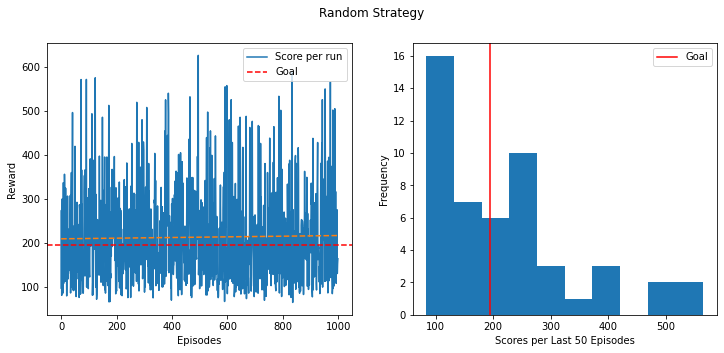

In [149]:
# Run The Random Strategy 'Training'
print(episodes)
random_search(env, episodes)

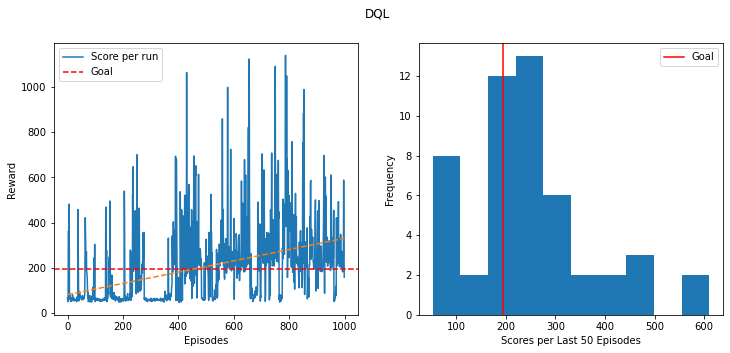

Episode: 1000, Total Reward: 158.84779367036074


In [150]:
# run simple DQL training
simple_dqn = DQN(n_state, n_action, n_hidden, lr)
q = q_learning(env, simple_dqn, episodes)

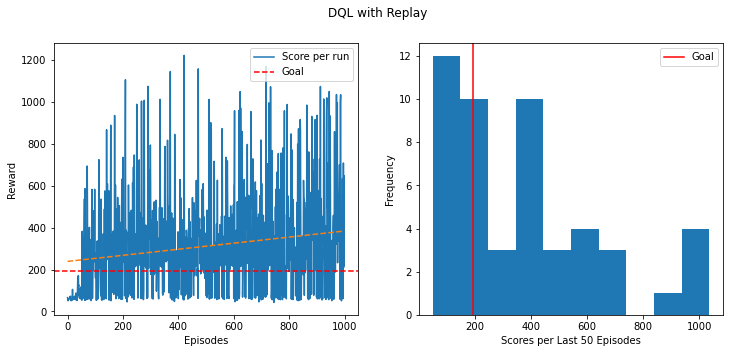

Episode: 1000, Total Reward: 223.672142520493
Average Replay Time:  0.4210489778518677


In [151]:
# Run the DQN_Replay Training
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')

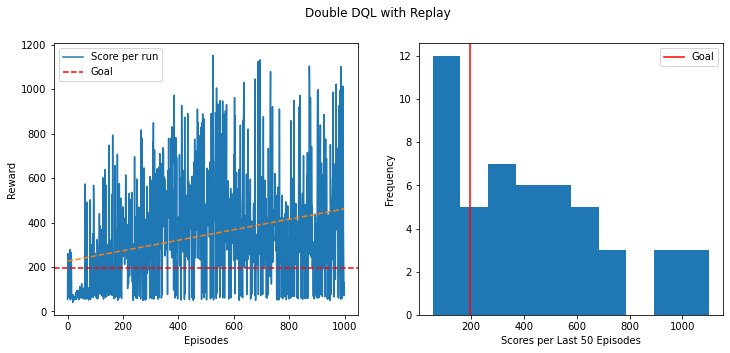

Episode: 1000, Total Reward: 128.12321128669853
Average Replay Time:  1.6253852417469026


In [156]:
# Train the Double DQN
dqn_double = DQN_double(n_state, n_action, n_hidden, lr)
double =  q_learning(env, dqn_double, episodes, gamma=.9, 
                    epsilon=0.2, replay=True, double=True,
                    title='Double DQL with Replay', n_update=10)

# Watching the Agents
The following cells can be used to generate a video of the agents running

In [47]:
# Run the simple DQL video
q = q_learning(env, simple_dqn, video_episodes, render=True)

Episode: 1, Total Reward: 97.23500055242663
Episode: 2, Total Reward: 447.2417528628254
Episode: 3, Total Reward: 134.29662407393008
Episode: 4, Total Reward: 423.3322755985662
Episode: 5, Total Reward: 78.99269840020749
Episode: 6, Total Reward: 604.502340972194
Episode: 7, Total Reward: 138.4703752476748
Episode: 8, Total Reward: 128.63946391607658
Episode: 9, Total Reward: 520.1721981408725
Episode: 10, Total Reward: 122.06702744047602


In [48]:
# Run the DQN Replay Video
replay = q_learning(env, dqn_replay, 
                    video_episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay', render=True)

Episode: 1, Total Reward: 340.8252306863079
Average Replay Time:  0.5918605327606201


<ipython-input-36-7efd70ae574e>:26: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


Episode: 2, Total Reward: 64.26436502377209
Average Replay Time:  0.39291417598724365
Episode: 3, Total Reward: 405.15845672566485
Average Replay Time:  0.4765658378601074
Episode: 4, Total Reward: 57.04308742472521
Average Replay Time:  0.4011468291282654
Episode: 5, Total Reward: 763.6324350408355
Average Replay Time:  0.5305521488189697
Episode: 6, Total Reward: 75.36256819159203
Average Replay Time:  0.4867204825083415
Episode: 7, Total Reward: 265.7959398665876
Average Replay Time:  0.47978813307625906
Episode: 8, Total Reward: 60.22505723522583
Average Replay Time:  0.43954354524612427
Episode: 9, Total Reward: 260.8915641188237
Average Replay Time:  0.44801486863030326
Episode: 10, Total Reward: 459.16384970212516
Average Replay Time:  0.47626824378967286


In [155]:
# Run the double_DQN Video
double =  q_learning(env, dqn_double, video_episodes, gamma=.9, 
                    epsilon=0.2, replay=True, double=True,
                    title='Double DQL with Replay', n_update=10, render=True)

Episode: 1, Total Reward: 545.3433595512915
Average Replay Time:  1.671663761138916
Episode: 2, Total Reward: 499.2173837604819
Average Replay Time:  2.397528290748596
Episode: 3, Total Reward: 63.1277890881536
Average Replay Time:  1.7796564102172852
Episode: 4, Total Reward: 414.0277785598557
Average Replay Time:  2.0688312649726868
Episode: 5, Total Reward: 58.53987891010538
Average Replay Time:  1.7658306121826173
Episode: 6, Total Reward: 138.38244927606715
Average Replay Time:  1.598466952641805
Episode: 7, Total Reward: 68.15874078339002
Average Replay Time:  1.462494203022548
Episode: 8, Total Reward: 104.24728019164394
Average Replay Time:  1.3776649236679077
Episode: 9, Total Reward: 64.78111597106304
Average Replay Time:  1.2967413001590304
Episode: 10, Total Reward: 105.73078212387527
Average Replay Time:  1.2498725175857544
